# PROGRAMMING LANGUAGE DETECTOR (PLD) - Version 2.0
### - BY NAZRI BAJURI

## METHOD 1: NATURAL LANGUAGE PROCESSING (NLP)

In [8]:
import logging
import re
from typing import Counter
import numpy as np
import os
from gensim.models import Word2Vec
from keras import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from numpy import asarray, zeros
import pickle

from src import config
from src.config import input_length

all_languages = ["Python", "C", "Java", "C#"]

### Database

In [9]:
#### DATABASE  - CONSTRUCT VOCAB ########
def load_words_from_string(s):
    contents = " ".join(s.splitlines())
    result = re.split(r"[{}()\[\]\'\":.*\s,#=_/\\><;?\-|+]", contents)

    # remove empty elements
    result = [word for word in result if word.strip() != ""]

    return result

#### BUILD VOCAB TOKENIZER ######

def save_vocab_tokenizer(vocab_tokenzier_location, vocab_tokenizer):
    with open(vocab_tokenzier_location, 'wb') as f:
        pickle.dump(vocab_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_vocab_tokenizer(vocab_tokenizer_location):
    with open(vocab_tokenizer_location, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer


def evaluate_saved_data(x_file_name, y_file_name, model):
    x = np.loadtxt(x_file_name)
    y = np.loadtxt(y_file_name)
    loss, accuracy = model.evaluate(x, y, verbose=2)
    print(f"loss: {loss}, accuracy: {accuracy}")


def to_binary_list(i, count):
    result = [0] * count
    result[i] = 1
    return result


def get_lang_sequence(lang):
    for i in range(len(all_languages)):
        if all_languages[i] == lang:
            return to_binary_list(i, len(all_languages))
    raise Exception(f"Language {lang} is not supported.")


def encode_sentence(sentence, vocab_tokenizer):
    encoded_sentence = vocab_tokenizer.texts_to_sequences(sentence.split())
    return [word[0] for word in encoded_sentence if len(word) != 0]


def load_vocab(vocab_location):
    with open(vocab_location) as f:
        words = f.read().splitlines()
    return set(words)


##### BUILD WORD VECTORS  #####


def load_word2vec(word2vec_location):
    result = dict()
    with open(word2vec_location, "r", encoding="utf-8") as f:
        lines = f.readlines()[1:]
    for line in lines:
        parts = line.split()
        result[parts[0]] = asarray(parts[1:], dtype="float32")
    return result


def load_model(model_file_location, weights_file_location):
    with open(model_file_location) as f:
        model = model_from_json(f.read())
    model.load_weights(weights_file_location)
    return model


def build_vocab_tokenizer_from_set(vocab):
    vocab_tokenizer = Tokenizer(lower=False, filters="")
    vocab_tokenizer.fit_on_texts(vocab)
    return vocab_tokenizer


def get_files(data_dir):
    result = []
    depth = 0
    for root, sub_folders, files in os.walk(data_dir):
        depth += 1

        # ignore the first loop
        if depth == 1:
            continue

        language = os.path.basename(root)
        result.extend([os.path.join(root, f) for f in files])
        depth += 1
    return result


def load_words_from_file(file_name):
    try:
        with open(file_name, "r") as f:
            contents = f.read()
    except UnicodeDecodeError:
        logging.warning(f"Encountered UnicodeDecodeError, ignore file {file_name}.")
        return []
    return load_words_from_string(contents)


def get_languages(ext_lang_dict):
    languages = set()
    for ext, language in ext_lang_dict.items():
        if type(language) is str:
            languages.update([language])
        elif type(language) is list:
            languages.update(language)
    return languages


def save_model(model, model_file_location, weights_file_location):
    os.makedirs(os.path.dirname(model_file_location), exist_ok=True)
    with open(model_file_location, "w") as f:
        f.write(model.to_json())
    model.save_weights(weights_file_location)


def save_vocabulary(vocabulary, file_location):
    with open(file_location, "w+") as f:
        for word in vocabulary:
            f.write(word + "\n")


def is_in_vocab(word, vocab_tokenizer):
    return word in vocab_tokenizer.word_counts.keys()


def concatenate_qualified_words(words, vocab_tokenizer):
    return " ".join([word for word in words if is_in_vocab(word, vocab_tokenizer)])


def load_sentence_from_file(file_name, vocab_tokenizer):
    words = load_words_from_file(file_name)
    return concatenate_qualified_words(words, vocab_tokenizer)


def load_sentence_from_string(s, vocab_tokenizer):
    words = load_words_from_string(s)
    return concatenate_qualified_words(words, vocab_tokenizer)


def load_encoded_sentence_from_file(file_name, vocab_tokenizer):
    sentence = load_sentence_from_file(file_name, vocab_tokenizer)
    return encode_sentence(sentence, vocab_tokenizer)


def load_encoded_sentence_from_string(s, vocab_tokenizer):
    sentence = load_sentence_from_string(s, vocab_tokenizer)
    return encode_sentence(sentence, vocab_tokenizer)


def load_data(data_dir, vocab_tokenizer):
    files = get_files(data_dir)
    x = []
    y = []
    for f in files:
        language = os.path.dirname(f).split(os.path.sep)[-1]
        x.append(load_encoded_sentence_from_file(f, vocab_tokenizer))
        y.append(get_lang_sequence(language))
    return pad_sequences(x, maxlen=input_length), asarray(y)


def build_vocab(train_data_dir):
    vocabulary = Counter()
    files = get_files(train_data_dir)
    for f in files:
        words = load_words_from_file(f)
        vocabulary.update(words)

    # remove rare words
    min_count = 5
    vocabulary = [word for word, count in vocabulary.items() if count >= min_count]
    return vocabulary


def build_word2vec(train_data_dir, vocab_tokenizer):
    all_words = []
    files = get_files(train_data_dir)
    for f in files:
        words = load_words_from_file(f)
        all_words.append([word for word in words if is_in_vocab(word, vocab_tokenizer)])
    model = Word2Vec(all_words, size=100, window=5, workers=8, min_count=1)
    return {word: model[word] for word in model.wv.index2word}


def get_word2vec_dimension(word2vec):
    first_vector = list(word2vec.values())[0]
    return len(first_vector)


def build_weight_matrix(vocab_tokenizer, word2vec):
    vocab_size = len(vocab_tokenizer.word_index) + 1
    word2vec_dimension = get_word2vec_dimension(word2vec)
    weight_matrix = zeros((vocab_size, word2vec_dimension))
    for word, index in vocab_tokenizer.word_index.items():
        weight_matrix[index] = word2vec[word]
    return weight_matrix


### Model Development

In [10]:
 ##### MODEL DEVELOPMENT #######


def build_model(train_data_dir, vocab_tokenizer, word2vec):
    weight_matrix = build_weight_matrix(vocab_tokenizer, word2vec)

    # build the embedding layer
    input_dim = len(vocab_tokenizer.word_index) + 1
    output_dim = get_word2vec_dimension(word2vec)
    x_train, y_train = load_data(train_data_dir, vocab_tokenizer)

    embedding_layer = Embedding(input_dim, output_dim, weights=[weight_matrix], input_length=input_length,
                                trainable=False)
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(len(all_languages), activation="sigmoid"))
    logging.info(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, verbose=2)
    return model


def evaluate_model(test_data_dir, vocab_tokenizer, model):
    x_test, y_test = load_data(test_data_dir, vocab_tokenizer)
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    logging.info('Test Accuracy: %f' % (acc * 100))


def build_and_save_vocab_tokenizer(train_data_dir, vocab_tokenizer_location):
    vocab = build_vocab(train_data_dir)
    vocab_tokenizer = build_vocab_tokenizer_from_set(vocab)
    save_vocab_tokenizer(vocab_tokenizer_location, vocab_tokenizer)
    return vocab_tokenizer


if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)

    vocab_tokenizer = build_and_save_vocab_tokenizer(config.train_data_dir, config.vocab_tokenizer_location)
    word2vec = build_word2vec(config.train_data_dir, vocab_tokenizer)

    model = build_model(config.train_data_dir, vocab_tokenizer, word2vec)
    evaluate_model(config.test_data_dir, vocab_tokenizer, model)

    save_model(model, config.model_file_location, config.weights_file_location)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 36822 word types from a corpus of 4922905 raw words and 345 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:min_count=1 retains 36822 unique words (100% of original 36822, drops 0)
INFO:gensim.models.word2vec:min_count=1 leaves 4922905 word corpus (100% of original 4922905, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 36822 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 43 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 4386798 word corpus (89.1% of prior 4922905)
INFO:gensim.models.base_any2vec:estimated required memory for 36822 words and 100 dimensions: 47868600 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:training model with 8 wor

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 4922905 raw words (253077 effective words) took 0.3s, 885293 effective words/s
INFO:gensim.models.base_any2vec:training on a 24614525 raw words (1265338 effective words) took 1.4s, 895386 effective words/s
/Users/nazribajuri/anaconda3/envs/PLDetector/lib/python3.6/site-packages/ipykernel_launcher.py:189: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
INFO:root:None


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          3682300   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 496, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 248, 128)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 31744)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 126980    
Total params: 3,873,408
Trainable params: 191,108
Non-trainable params: 3,682,300
_________________________________________________________________
Epoch 1/10
 - 2s - loss: 0.9839 - acc: 0.7210
Epoch 2/10
 - 1s - loss: 0.4516 - acc: 0.7964
Epoch 3/10
 - 1s - loss: 0.3257 - 

INFO:root:Test Accuracy: 88.750000


### Neural Network For Detection

In [19]:
### NEURAL NETWORK FOR DETECTION #####


import numpy as np
from keras.preprocessing.sequence import pad_sequences
from src import config
from src.config import input_length
from src.neural_network_trainer import load_model, \
    load_vocab_tokenizer, load_encoded_sentence_from_string, all_languages

vocab_tokenizer = load_vocab_tokenizer(config.vocab_tokenizer_location)
model = load_model(config.model_file_location, config.weights_file_location)


def to_language(binary_list):
    i = np.argmax(binary_list)
    return all_languages[i]


def get_neural_network_input(code):
    encoded_sentence = load_encoded_sentence_from_string(code, vocab_tokenizer)
    return pad_sequences([encoded_sentence], maxlen=input_length)


def detect(code):
    y_proba = model.predict(get_neural_network_input(code))
    return to_language(y_proba)

### Output - Detect the Language Type
#### Ask user to upload file which has the programming language to be identified

In [20]:
if __name__ == "__main__":
    code = input("Please copy and paste the language you want to identify: ")
    bold_start = '\033[1m'
    bold_end   = '\033[0m'
    
    print("The language type is:",bold_start, detect(code), bold_end)

Please copy and paste the language you want to identify: /*  * IndestructibleBlock.java		$Date: 2004/03/28 16:28:44 $  *  * Paul Mucur (0346349)  * CMPS1A4Y (Programming - Languages and Software Construction)  *  * A class to represent an indestructible block.  */  import java.awt.*; import javax.swing.*;  public class IndestructibleBlock extends Block { 	 	/* Overridden paintComponent method to display the block as a 3D square. */ 	protected void paintComponent(Graphics g) { 	 		/* Set the colour of the Graphics object to the colour of the block. */ 		g.setColor(Color.lightGray); 		 		/* Fill a 3D raised rectangle with the colour. */ 		g.fill3DRect(0, 0, getWidth(), getHeight(), true); 		 		/*  		 * Cast the Graphics object into a Graphics2D object to paint the  		 * block. 		 */ 		Graphics2D g2d = (Graphics2D)g.create(); 		 		/* Dispose of the Graphics2D object. */ 		g2d.dispose(); 	} 	 	public void click() { 		 		/* Do nothing. */ 	} }
The language type is:  Java 


In [7]:
print("The language type is:",bold_start, detect(code), bold_end)

The language type is:  Java 


## METHOD 2 - COMPUTER VISION 

Uses standard image classification models to classify images of source code.

## Setup

Set up Jupyter Notebook, import packages, set some constants.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from pathlib import Path

from fastai import *
from fastai.vision import *

In [4]:
PATH = 'data/renders/'

bs = 64
model_id = 'model-1'

tfms = []
size = 299


## Load data

In [4]:
def load_images():
    """ Loads images in PATH, sorting them into classes based on the subdirectory name.
    """
    p = Path(PATH)
    files = []
    classes = []
    for subdir in p.ls():
        for fn in subdir.glob('*.png'):
            files.append(fn)
            classes.append(subdir.name)

    return ImageDataBunch.from_lists(PATH, files, classes, ds_tfms=tfms, bs=bs, size=size)

data = load_images()


In [5]:
# Show the classes (categories)
print(len(data.classes), data.classes)


4 ['c', 'csharp', 'java', 'python']


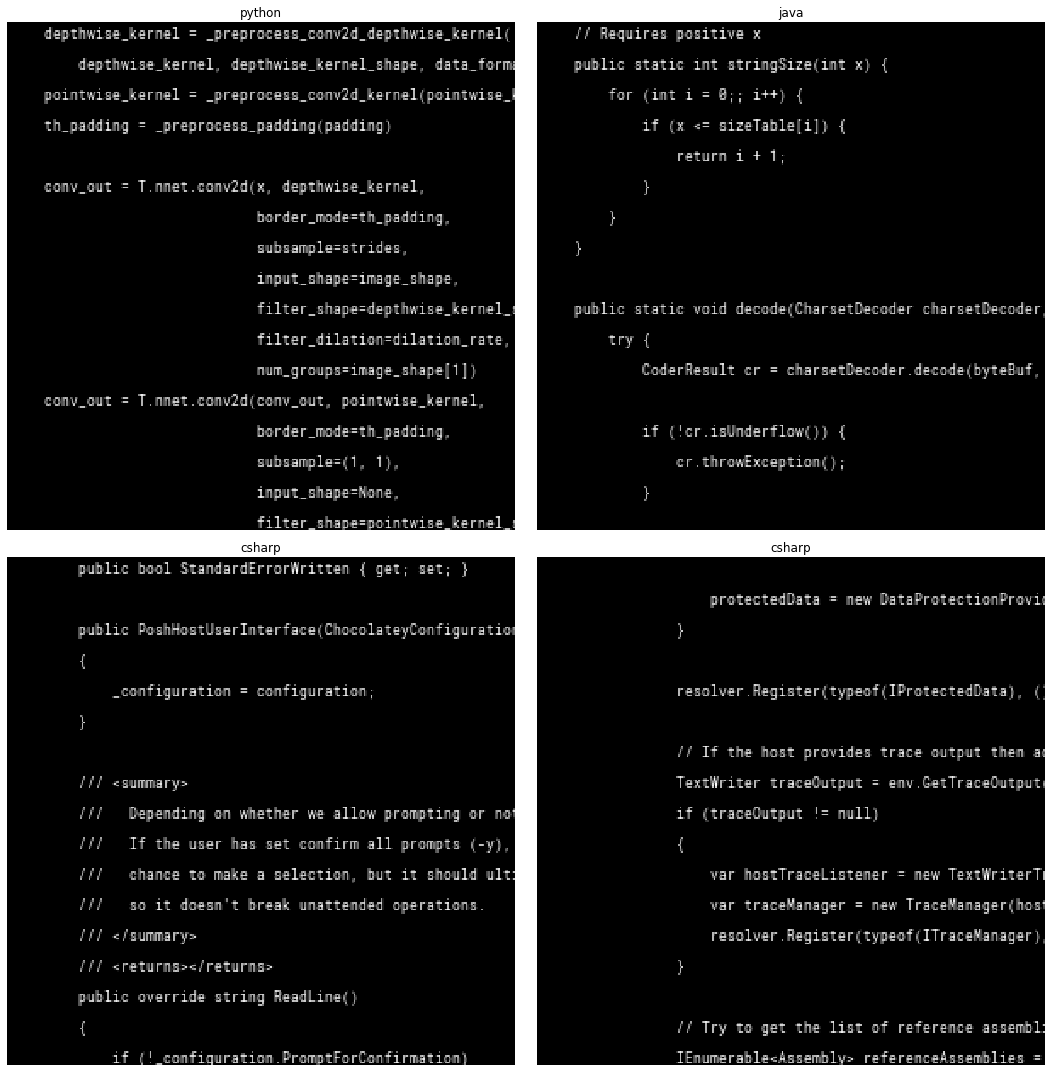

In [6]:
# Show some sample images
data.show_batch(rows=2, figsize=(15, 15))

## Model

Based on ResNet34.

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

### Initial training

Only trains the final layer of the model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


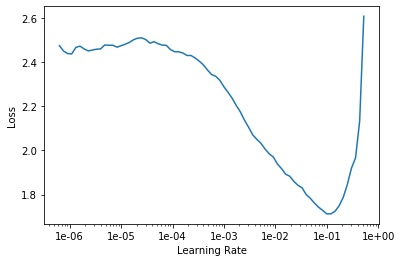

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(4, 1e-01)

epoch,train_loss,valid_loss,error_rate,time
0,1.784450,9.552729,0.722500,14:54
1,1.618305,17.242117,0.737500,17:26
2,1.179213,5.254401,0.502500,14:31
3,0.793023,0.264818,0.067500,14:39


In [10]:
learn.save(f'{model_id}-stage-1')

### Unfreeze and train the full model

Train the full model (i.e. all layers) with smaller learning rates. This basically fine-tunes the earlier layers to better fit the new task it is given.

In [11]:
learn.load(f'{model_id}-stage-1')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


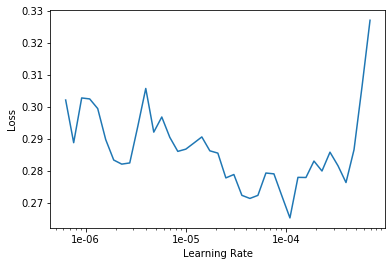

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(4, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.231474,0.166425,0.052500,22:05
1,0.217524,0.115937,0.045000,20:40
2,0.163252,0.110927,0.030000,1:46:08
3,0.136071,0.105245,0.030000,2:27:49


In [14]:
learn.save(f'{model_id}-stage-2')

## Explore the results

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

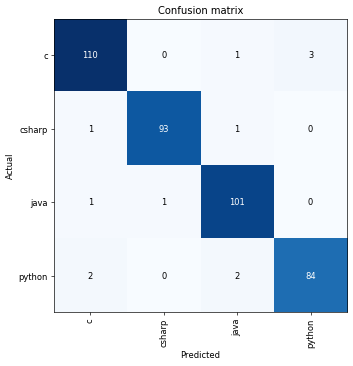

In [16]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [17]:
# Most confused categories, e.g. first line tells that C code was mistaken to be C++ quite often.
interp.most_confused()

[('c', 'python', 3),
 ('python', 'c', 2),
 ('python', 'java', 2),
 ('c', 'java', 1),
 ('csharp', 'c', 1),
 ('csharp', 'java', 1),
 ('java', 'c', 1),
 ('java', 'csharp', 1)]

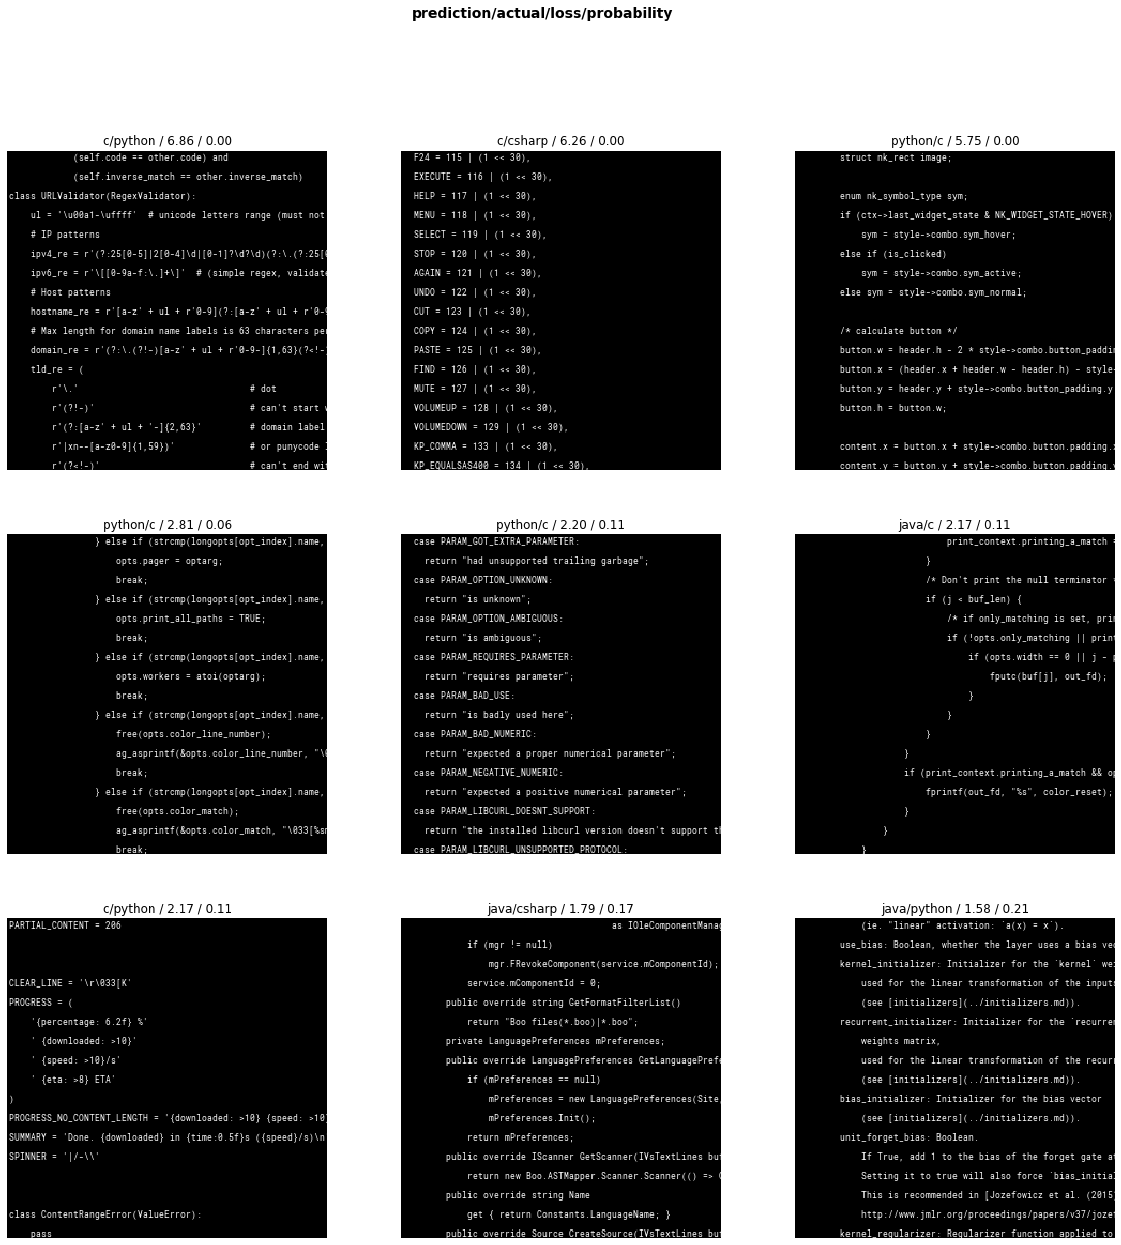

In [18]:
# Let's see the most incorrect predictions
interp.plot_top_losses(9, figsize=(20,20))

In [19]:
#This will create a file named 'export.pkl' in the directory where we were working that contains everything 
#we need to deploy our model (the model, the weights but also some metadata like the classes or the 
#transforms/normalization used).

learn.export()  


In [20]:
path = Path("data/renders/")
path

PosixPath('data/renders')

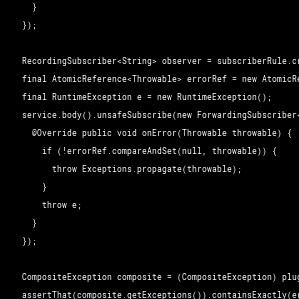

In [21]:
img = open_image(path/'java'/'007.png')
img

In [22]:
#We create our Learner in production enviromnent like this, jsut make sure that path contains the file 'export.pkl' 
#from before.

learn = load_learner(path)

In [23]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category java

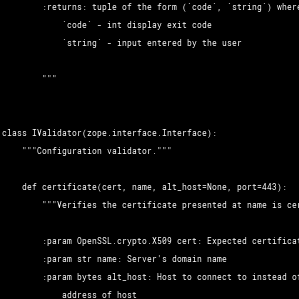

In [25]:
img = open_image(path/'python'/'007.png')
img

In [26]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category python

### Test using Test Dataset

In [22]:
path = Path("data/test/")
path

PosixPath('data/test')

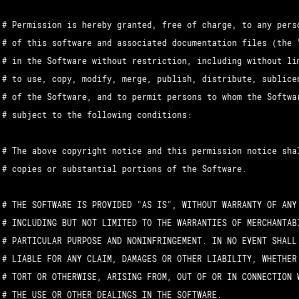

In [23]:
img = open_image(path/'python'/'007.png')
img

In [24]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category python

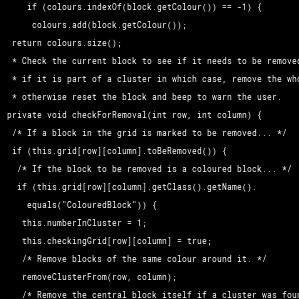

In [82]:
img = open_image(path/'java'/'371.png')
img

In [83]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category java